In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading Required Packages

In [6]:
!pip install pytesseract pdf2image pillow opencv-python matplotlib pymupdf && \
pip install nltk PyPDF2 pdfplumber pycryptodome && \
pip install pdfplumber && \
pip install nltk sentence-transformers scikit-learn && \
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.4 MB/s eta 0:00:00



# Project IA-Cognition

This notebook is part of the **A content based recommender system on Risk Mangement** project. The goal of this project is to analyze textual data, extract meaningful features, and evaluate the relevance of extracted concepts using various natural language processing techniques. The project includes cleaning data, extracting attributes and relations from text, calculating term frequencies, and evaluating the performance of feature extraction.

This notebook is organized as follows:
1. **Data Extraction**
2. **Data Segmentation**
3. **Concept and Relationship Identification**
4. **Process Evaluation**


# I- Text Extraction & Processing


# Imports

In [7]:
# Data Handling
import pandas as pd
import numpy as np

# PDF Processing
import pdfplumber
import fitz
from pdf2image import convert_from_path

# Image Processing
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import pytesseract

# Text Processing
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import RegexpParser
from nltk.probability import FreqDist
from collections import Counter, defaultdict

# Natural Language Processing
import spacy
from sentence_transformers import SentenceTransformer
from nltk.parse.corenlp import CoreNLPDependencyParser

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

# String Distance
import Levenshtein
from Levenshtein import distance as levenshtein_distance

# Concurrent Processing
import concurrent.futures

# Visualization
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange



# Data Extraction



In [8]:
# Download NLTK data (if not already downloaded)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)


True

In [9]:

# Define the path to your PDF file
pdf_path = '/content/drive/MyDrive/practice-standard-project-risk-management.pdf'

In [10]:
# Initialize a list to store text from all pages
extracted_text = []

In [11]:
nltk.download('stopwords')

# Load the default English stopwords
stop_words = set(stopwords.words('english'))

# Define your custom stop words
custom_stop_words = {
    # Articles
    'a', 'an', 'the',

    # Prepositions
    'in', 'on', 'at', 'by', 'for', 'with', 'of',

    # Conjunctions
    'and', 'or', 'but', 'if',

    # Pronouns
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'this', 'that',

    # Common Verbs
    'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'do', 'does',

    # Adverbs
    'very', 'so', 'just',

    # Quantifiers
    'all', 'some', 'many', 'most',

    # Additional Words
    'other', 'chapter', 'appendix',

    # Single Letters
    'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

    # Specific Words and Numbers
    '2009', 'to', 'can', 'may', 'of','.'
}

# Update the NLTK stopwords with the custom stopwords
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
def clean_text(text):
    # Normalize unicode characters (remove accents)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    # Convert text to lowercase
    text = text.lower()
    # Remove ellipses (sequences of three or more periods)
    text = re.sub(r'\.{3,}', ' ', text)
    # Remove any other unwanted patterns
    # Remove digits
    # text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters except spaces
    text = re.sub(r'[^\w\s]', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Removes any non-ASCII characters
    # Strip leading and trailing spaces
    text = text.strip()

    return text

In [14]:

start_page = 13  # Start from page 13
end_page = 118   # End at page 117 (inclusive)
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:
    # Iterate through each page

    for page_number, page in enumerate(pdf.pages[start_page - 1:end_page], start=start_page):## to verify
        text = page.extract_text()
        if text:
            # Clean the text
            text = clean_text(text)
            # Tokenize the text into words
            tokens = word_tokenize(text)
            # Lemmatize the tokens
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            # Remove stop words
            tokens_without_stopwords = [word for word in tokens if word not in stop_words]
            # Reconstruct cleaned text
            cleaned_text = ' '.join(tokens_without_stopwords)
            # Append the cleaned text to the list
            extracted_text.append(cleaned_text)
        else:
            print(f"--- Page {page_number} ---\nNo text found on this page.\n")

# Now you can join all the page texts into a single string
full_text = ' '.join(extracted_text)

# Tokenize the text into sentences
sentences = sent_tokenize(full_text)

# (Optional) Print the sentences
for idx, sentence in enumerate(sentences, start=1):
    print(f"Sentence {idx}: {sentence}\n")


--- Page 20 ---
No text found on this page.

--- Page 30 ---
No text found on this page.

--- Page 36 ---
No text found on this page.

--- Page 42 ---
No text found on this page.

--- Page 48 ---
No text found on this page.

--- Page 68 ---
No text found on this page.

--- Page 70 ---
No text found on this page.

--- Page 80 ---
No text found on this page.

--- Page 118 ---
No text found on this page.

Sentence 1: 1 1 introduction roject management institute pmi practice standard guide use tool technique process identifi ed guide project management body knowledge pmbok uide fourth edition pmi standard practice standard targeted audience participate management project includes project manager project personnel contract personnel supervisor project stakeholder pmi practice standard describes process activity input output specifi knowledge area provides information signifi cant process tool technique doe signifi cant performed executed necessary clarifi cation perform process practice sta

# Data Segmentation

NLTK’s lemmatizer requires WordNet POS tags for more accurate results due to the following reasons:

NLTK POS Tags: These tags, generated by NLTK's pos_tag function, classify words into parts of speech such as nouns, verbs, adjectives, and adverbs (e.g., NN for nouns, VB for verbs).

WordNet Lemmatizer: To effectively lemmatize words, it is crucial to inform the lemmatizer of each word's part of speech. NLTK's WordNetLemmatizer performs optimally when provided with WordNet's POS tags (e.g., wordnet.NOUN, wordnet.VERB).

In summary, this step prepares the environment for extracting, processing, and lemmatizing text, which are fundamental tasks in NLP workflows. This organization ensures that the correct POS tags are utilized, allowing the lemmatized text to be stored for future use.

In [15]:
def get_wordnet_pos(nltk_pos_tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if nltk_pos_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # Default to noun

In [16]:
# Initialize a list to store all lemmatized tokens with POS tags
all_lemmatized_pos_tags = []

In [17]:
extracted_text = []

In [18]:
# Open the PDF file
tokens=[]
# Initialize a list to store text from all pages
extracted_text = []
with pdfplumber.open(pdf_path) as pdf:
    # Iterate through each page
    for page_number, page in enumerate(pdf.pages[start_page - 1:end_page], start=start_page):
        text = page.extract_text()
        if text:
            # Clean the text
            text = clean_text(text)
            extracted_text.append(text)
            # Tokenize the text into words
            tokens = word_tokenize(text)
            # Remove stop words
            tokens = [token for token in tokens if token not in stop_words]
            # Perform POS tagging
            pos_tags = nltk.pos_tag(tokens)
            # Lemmatize tokens with POS tags
            lemmatized_tokens = []
            for token, tag in pos_tags:
                wordnet_pos = get_wordnet_pos(tag)
                lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos)
                lemmatized_tokens.append((lemmatized_token, tag))
            # Collect all lemmatized tokens with POS tags
            all_lemmatized_pos_tags.extend(lemmatized_tokens)
        else:
            pass  # Skip pages with no text

In [19]:
# Create a DataFrame from all_lemmatized_pos_tags
df_tokens = pd.DataFrame(all_lemmatized_pos_tags, columns=['Word', 'POS Tag'])

# Calculate frequency of each word and POS Tag
df_freq = df_tokens.groupby(['Word', 'POS Tag']).size().reset_index(name='Frequency')

# Sort by frequency
df_freq = df_freq.sort_values(by='Frequency', ascending=False)

# Rearrange columns
df_freq = df_freq[['Word', 'POS Tag', 'Frequency']]

# Display combined table
print("Combined Table of Words with POS Tags:")
print(df_freq.head(20).to_string(index=False))


Combined Table of Words with POS Tags:
       Word POS Tag  Frequency
       risk      NN        878
    project      NN        782
 management      NN        632
       risk     NNS        335
   analysis      NN        189
        pmp      NN        166
   practice      NN        155
    process      NN        151
   standard      NN        149
       plan      NN        115
  institute      NN         99
   response     NNS         94
    project     VBP         93
       risk     VBP         87
stakeholder     NNS         83
   response      NN         79
  technique     NNS         77
information      NN         73
     action     NNS         70
    project     NNS         66


# Concept and Relationship Identification

In this process, we identify key concepts from the text by focusing on high-frequency words, specifically nouns and proper nouns. We begin by defining relevant part-of-speech (POS) tags for nouns and proper nouns and then filter the tokenized data to retain only these words. Next, we calculate the frequency of each concept by grouping the filtered data and counting occurrences, storing the results in a new DataFrame. The frequency data is then sorted in descending order to highlight the most common concepts, with the top 20 concepts extracted and displayed for further analysis. This method effectively highlights essential concepts within the text for subsequent tasks.

In [20]:
# ------------------- Concept Identification ------------------- #
# Identify concepts based on high-frequency words (nouns and proper nouns)
concept_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']
df_concepts = df_tokens[df_tokens['POS Tag'].isin(concept_pos_tags)]

# Calculate frequency of each concept
df_concept_freq = df_concepts.groupby('Word').size().reset_index(name='Frequency')

# Sort by frequency
df_concept_freq = df_concept_freq.sort_values(by='Frequency', ascending=False)

# Display the most pertinent concepts
most_common_concepts = df_concept_freq.head(20)

print("\nMost Pertinent Concepts:")
print(most_common_concepts.to_string(index=False))


Most Pertinent Concepts:
       Word  Frequency
       risk       1213
    project        848
 management        633
   analysis        192
   response        173
   standard        169
    process        168
        pmp        166
   practice        163
       plan        137
  technique        120
  institute         99
     action         98
stakeholder         91
      level         81
    example         78
information         73
       cost         72
       time         64
     impact         62


In [21]:
# ------------------- Attribute and Relation Extraction ------------------- #
# Process text at the sentence level using more comprehensive patterns
attributes = []
relations = []

# Reconstruct the full text
full_text = ' '.join(extracted_text)

# Tokenize text into sentences
sentences = sent_tokenize(full_text)

for sentence in sentences:
    # Tokenize and POS tag
    tokens = word_tokenize(sentence)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    pos_tags = nltk.pos_tag(tokens)
    # Lemmatize tokens with POS tags
    lemmatized_tokens = []
    for token, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos)
        lemmatized_tokens.append((lemmatized_token.lower(), tag))
    # Update tokens and pos_tags with lemmatized tokens
    tokens = [token for token, tag in lemmatized_tokens]
    pos_tags = [(token, tag) for token, tag in lemmatized_tokens]
    # Build chunk grammar to capture more patterns
    grammar = r"""
        ATTRIBUTE: {<NN.*><IN><NN.*>}          # Noun + Preposition + Noun
                  {<JJ.*><NN.*>}               # Adjective(s) + Noun
                  {<NN.*><NN.*>}               # Noun + Noun compounds
        RELATION: {<NN.*><VB.*><NN.*>}         # Noun + Verb + Noun
                 {<NN.*><VB.*><IN><NN.*>}      # Noun + Verb + Preposition + Noun
    """
    # Create chunk parser
    cp = RegexpParser(grammar)
    tree = cp.parse(pos_tags)
    # Extract attributes
    for subtree in tree.subtrees(filter=lambda t: t.label() == 'ATTRIBUTE'):
        words, tags = zip(*subtree.leaves())
        attribute = ' '.join(words)
        attributes.append(attribute)
    # Extract relations
    for subtree in tree.subtrees(filter=lambda t: t.label() == 'RELATION'):
        words, tags = zip(*subtree.leaves())
        relation = ' '.join(words)
        relations.append(relation)

In [22]:
# Calculate frequencies of attributes
attribute_freq = FreqDist(attributes)
most_common_attributes = attribute_freq.most_common(20)

In [23]:
# Display attributes
print("\nAttributes Linked to Concepts:")
print("{:<50}{}".format("Attribute Phrase", "Frequency"))
print("-" * 65)
for attribute, freq in most_common_attributes:
    print("{:<50}{}".format(attribute, freq))


Attributes Linked to Concepts:
Attribute Phrase                                  Frequency
-----------------------------------------------------------------
risk management                                   207
project risk                                      135
project management                                96
standard project                                  66
practice standard                                 65
institute practice                                53
management institute                              46
quantitative risk                                 45
risk response                                     38
qualitative risk                                  35
individual risk                                   35
overall project                                   33
management process                                32
identifi cation                                   31
plan risk                                         26
identify risk                                

In [24]:
# Calculate frequencies of relations
relation_freq = FreqDist(relations)
most_common_relations = relation_freq.most_common(20)

In [25]:
# Display relations
print("\nRelations Between Concepts:")
print("{:<60}{}".format("Relation Phrase", "Frequency"))
print("-" * 75)
for relation, freq in most_common_relations:
    print("{:<60}{}".format(relation, freq))



Relations Between Concepts:
Relation Phrase                                             Frequency
---------------------------------------------------------------------------
technique examples template                                 3
strength weaknesses application                             3
management process defi                                     2
project follow element                                      2
project objectives risk                                     2
risk occur project                                          2
plan risk response                                          2
project templates example                                   2
program portfolios project                                  1
textbook handbooks course                                   1
management identify risk                                    1
process describe address                                    1
refl ecting business                                        1
principle describe 

In [26]:

# Initialize a list to store all sentences
sentences = []

# Initialize the WordNet lemmatizer
# lemmatizer = WordNetLemmatizer()

# Get the list of English stop words
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     # Normalize unicode characters (remove accents)
#     text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
#     # Convert text to lowercase
#     text = text.lower()
#     # Remove punctuation except hyphens (useful for compound words) and periods (useful for abbreviations)
#     text = re.sub(r'[^\w\s\.-]', '', text)
#     # Remove multiple spaces
#     text = re.sub(r'\s+', ' ', text)
#     # Strip leading and trailing spaces
#     text = text.strip()
#     return text

def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # Default to noun

# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            # Clean the text
            text = clean_text(text)
            # Tokenize text into sentences
            raw_sentences = sent_tokenize(text)
            for raw_sentence in raw_sentences:
                # Tokenize the sentence into words
                tokens = word_tokenize(raw_sentence)
                # Remove stop words and lemmatize tokens
                filtered_tokens = []
                pos_tags = nltk.pos_tag(tokens)
                for token, tag in pos_tags:
                    if token not in stop_words:
                        wordnet_pos = get_wordnet_pos(tag)
                        lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos)
                        filtered_tokens.append(lemmatized_token)
                if filtered_tokens:
                    sentences.append(filtered_tokens)
        else:
            pass  # Skip pages with no text

# Flatten the list of sentences to create a list of all tokens
all_tokens = [token for sentence in sentences for token in sentence]

# Create a DataFrame from all_tokens
df_tokens = pd.DataFrame(all_tokens, columns=['Word'])

# Calculate frequency of each word
df_word_freq = df_tokens['Word'].value_counts().reset_index()
df_word_freq.columns = ['Word', 'Frequency']

# Sort by frequency
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Get the top N words as the most pertinent concepts
N = 10  # You can change N to get more or fewer concepts
most_common_concepts = df_word_freq.head(N)

print("\nMost Pertinent Concepts:")
print(most_common_concepts.to_string(index=False))

# Get unique words for embedding
unique_words = df_tokens['Word'].unique()

# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each unique word
word_embeddings = model.encode(unique_words, show_progress_bar=True)

# Create a dictionary to map words to their embeddings
word_to_embedding = dict(zip(unique_words, word_embeddings))

# Function to find top similar words for a given word
def find_similar_words(target_word, word_to_embedding, top_n=5):
    if target_word not in word_to_embedding:
        return []
    target_embedding = word_to_embedding[target_word].reshape(1, -1)
    # Exclude the target word from the list of words to compare
    words = [word for word in unique_words if word != target_word]
    embeddings = np.array([word_to_embedding[word] for word in words])
    similarities = cosine_similarity(target_embedding, embeddings)[0]
    # Get indices of top similar words
    similar_indices = similarities.argsort()[::-1][:top_n]
    similar_words = [(words[idx], similarities[idx]) for idx in similar_indices]
    return similar_words

# Identify synonyms within the extracted text
print("\nSynonyms Within Extracted Text:")
for word in most_common_concepts['Word']:
    similar_words = find_similar_words(word, word_to_embedding, top_n=5)
    if similar_words:
        print(f"\nWord: {word}")
        print("Similar Words:")
        for sim_word, score in similar_words:
            print(f"  {sim_word} (Similarity: {score:.4f})")
    else:
        print(f"\nWord: {word}")
        print("  No similar words found in the extracted text.")



Most Pertinent Concepts:
      Word  Frequency
      risk       1707
   project       1154
management        751
   process        297
  analysis        259
      plan        233
  standard        223
  response        215
  practice        191
       pmp        188


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/101 [00:00<?, ?it/s]


Synonyms Within Extracted Text:

Word: risk
Similar Words:
  risks (Similarity: 0.9197)
  riskrelated (Similarity: 0.7320)
  riskguidance (Similarity: 0.7187)
  safety (Similarity: 0.6168)
  threats (Similarity: 0.6008)

Word: project
Similar Words:
  task (Similarity: 0.5643)
  idea (Similarity: 0.5636)
  need (Similarity: 0.5422)
  attempt (Similarity: 0.5378)
  research (Similarity: 0.5348)

Word: management
Similar Words:
  managing (Similarity: 0.8936)
  managerial (Similarity: 0.8539)
  manage (Similarity: 0.8503)
  manager (Similarity: 0.8017)
  organisation (Similarity: 0.7037)

Word: process
Similar Words:
  processrelated (Similarity: 0.6600)
  processesrisk (Similarity: 0.6553)
  execution (Similarity: 0.5894)
  procedure (Similarity: 0.5794)
  production (Similarity: 0.5476)

Word: analysis
Similar Words:
  analyze (Similarity: 0.7923)
  evaluation (Similarity: 0.6173)
  analytic (Similarity: 0.5817)
  examine (Similarity: 0.5607)
  research (Similarity: 0.5536)

Word: pla

# Process Evaluation

In this section, we perform two key analyses: calculating the Levenshtein distance for synonyms and computing the TF-IDF scores for the extracted text. First, we define a function to calculate the Levenshtein distance, which measures the similarity between a given word and its similar words, as identified through a previously defined method (find_similar_words). For each word in the list of most common concepts, we find the top five similar words and print the Levenshtein distance along with cosine similarity values. If no similar words are found, a message is displayed accordingly.

Next, we proceed to calculate TF-IDF scores to assess the importance of words in the context of the extracted text. We rebuild the cleaned and lemmatized sentences into a list, which is then transformed into a TF-IDF matrix using TfidfVectorizer. This matrix quantifies the importance of each word across all sentences. We extract the feature names (terms) and their corresponding mean TF-IDF scores, storing them in a DataFrame. Finally, we sort this DataFrame by TF-IDF score in descending order and print the top 20 words with the highest scores, providing insights into the most significant terms within the text.

In [27]:
def clean_text(text):
    # Normalize unicode characters (remove accents)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation except hyphens and periods
    text = re.sub(r'[^\w\s\.-]', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing spaces
    text = text.strip()
    return text

def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # Default to noun

# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            # Clean the text
            text = clean_text(text)
            # Tokenize text into sentences
            raw_sentences = sent_tokenize(text)
            for raw_sentence in raw_sentences:
                # Tokenize the sentence into words
                tokens = word_tokenize(raw_sentence)
                # Remove stop words and lemmatize tokens
                filtered_tokens = []
                pos_tags = nltk.pos_tag(tokens)
                for token, tag in pos_tags:
                    if token not in stop_words:
                        wordnet_pos = get_wordnet_pos(tag)
                        lemmatized_token = lemmatizer.lemmatize(token, wordnet_pos)
                        filtered_tokens.append(lemmatized_token)
                if filtered_tokens:
                    sentences.append(filtered_tokens)
        else:
            pass  # Skip pages with no text

# Flatten the list of sentences to create a list of all tokens
all_tokens = [token for sentence in sentences for token in sentence]

# Create a DataFrame from all_tokens
df_tokens = pd.DataFrame(all_tokens, columns=['Word'])

# Calculate frequency of each word
df_word_freq = df_tokens['Word'].value_counts().reset_index()
df_word_freq.columns = ['Word', 'Frequency']

# Sort by frequency
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Get the top N words as the most pertinent concepts
N = 10  # You can change N to get more or fewer concepts
most_common_concepts = df_word_freq.head(N)

print("\nMost Pertinent Concepts:")
print(most_common_concepts.to_string(index=False))

# Get unique words for embedding
unique_words = df_tokens['Word'].unique()

# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each unique word
word_embeddings = model.encode(unique_words, show_progress_bar=True)

# Create a dictionary to map words to their embeddings
word_to_embedding = dict(zip(unique_words, word_embeddings))

# Function to find top similar words for a given word
def find_similar_words(target_word, word_to_embedding, top_n=5):
    if target_word not in word_to_embedding:
        return []
    target_embedding = word_to_embedding[target_word].reshape(1, -1)
    # Exclude the target word from the list of words to compare
    words = [word for word in unique_words if word != target_word]
    embeddings = np.array([word_to_embedding[word] for word in words])
    similarities = cosine_similarity(target_embedding, embeddings)[0]
    # Get indices of top similar words
    similar_indices = similarities.argsort()[::-1][:top_n]
    similar_words = [(words[idx], similarities[idx]) for idx in similar_indices]
    return similar_words

# Function to calculate Levenshtein distance
def calculate_levenshtein_distance(word, similar_words):
    print(f"\nLevenshtein Distances for the word '{word}':")
    for similar_word, similarity in similar_words:
        distance = Levenshtein.distance(word, similar_word)
        print(f"  {word} -> {similar_word}: Levenshtein Distance = {distance}, Cosine Similarity = {similarity:.4f}")

# Identify synonyms within the extracted text and calculate Levenshtein distance
print("\nSynonyms and Levenshtein Distances Within Extracted Text:")
for word in most_common_concepts['Word']:
    similar_words = find_similar_words(word, word_to_embedding, top_n=5)
    if similar_words:
        print(f"\nWord: {word}")
        print("Similar Words and Their Distances:")
        calculate_levenshtein_distance(word, similar_words)
    else:
        print(f"\nWord: {word}")
        print("  No similar words found in the extracted text.")



Most Pertinent Concepts:
      Word  Frequency
      risk       3414
   project       2306
management       1502
   process        594
  analysis        518
      plan        459
  standard        446
  response        432
  practice        382
       pmp        376


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/116 [00:00<?, ?it/s]


Synonyms and Levenshtein Distances Within Extracted Text:

Word: risk
Similar Words and Their Distances:

Levenshtein Distances for the word 'risk':
  risk -> risks: Levenshtein Distance = 1, Cosine Similarity = 0.9197
  risk -> risk-related: Levenshtein Distance = 8, Cosine Similarity = 0.8580
  risk -> riskrelated: Levenshtein Distance = 7, Cosine Similarity = 0.7320
  risk -> riskguidance: Levenshtein Distance = 8, Cosine Similarity = 0.7187
  risk -> non-risks: Levenshtein Distance = 5, Cosine Similarity = 0.7116

Word: project
Similar Words and Their Distances:

Levenshtein Distances for the word 'project':
  project -> project-: Levenshtein Distance = 1, Cosine Similarity = 0.8335
  project -> project-specific: Levenshtein Distance = 9, Cosine Similarity = 0.6084
  project -> project-related: Levenshtein Distance = 8, Cosine Similarity = 0.5837
  project -> project-wide: Levenshtein Distance = 5, Cosine Similarity = 0.5824
  project -> task: Levenshtein Distance = 7, Cosine Simi

In [28]:

# ------------- TF-IDF Calculation ------------- #

# Rebuild the cleaned, lemmatized sentences for TF-IDF vectorization
cleaned_sentences = [' '.join(sentence) for sentence in sentences]

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_sentences)

# Store the vocab (terms) and their importance scores (TF-IDF)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()  # Mean TF-IDF across all documents
tfidf_df = pd.DataFrame({'Word': tfidf_feature_names, 'TF-IDF Score': tfidf_scores})

# Sort the words by their TF-IDF score (descending order)
tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)

print("\nTop 20 Words by TF-IDF Score:")
print(tfidf_df.head(20).to_string(index=False))


Top 20 Words by TF-IDF Score:
       Word  TF-IDF Score
       risk      0.109692
    project      0.100289
 management      0.087584
   standard      0.040488
  institute      0.039991
   practice      0.038371
    process      0.033015
       plan      0.028025
   analysis      0.026495
   response      0.025326
        use      0.019927
     action      0.018914
  objective      0.018394
    example      0.017402
   identifi      0.017350
  technique      0.017025
     figure      0.015023
stakeholder      0.014704
     impact      0.014166
   identify      0.014025


In [29]:
# ------------- F-Measure Evaluation ------------- #

# Assuming 'most_common_concepts' from your previous code are True Positives
tp_words = most_common_concepts['Word'].tolist()

# Consider top N words by TF-IDF as predicted relevant concepts
N = 10
predicted_concepts = tfidf_df.head(N)['Word'].tolist()

# Create a binarizer
mlb = MultiLabelBinarizer(classes=list(set(tp_words) | set(predicted_concepts)))

# Binarize the true and predicted categories
y_true = mlb.fit_transform([tp_words])[0]  # Actual (True Relevant Concepts)
y_pred = mlb.fit_transform([predicted_concepts])[0]  # Predicted Concepts (TF-IDF Top N)

# Calculate Precision, Recall and F1-Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [30]:

# Output Precision, Recall and F1-Score
print("\n--- F-Measure Evaluation ---")
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


--- F-Measure Evaluation ---
Precision: 0.9000
Recall:    0.9000
F1-Score: 0.9000


# II- Image Extraction & Processing

---
In this section, we focus on extracting text from images embedded in the book. We will develop and implement two different methods for image extraction and processing. Each method is tailored for different use cases depending on the complexity and content of the images. Below are the detailed approaches:





In [31]:
import os
# Create a directory to save the extracted images
output_dir = "extracted_images"
os.makedirs(output_dir, exist_ok=True)

start_page = 13  # Start from page 13
end_page = 118   # End at page 117 (inclusive)

# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:
    # Iterate through each page
    for page_number in range(start_page - 1, end_page):  # Adjust for zero-based index
        page = pdf.pages[page_number]

        # Check for images on the page
        images = page.images

        if images:
            for img_index, img in enumerate(images):
                # Extract the image data using the bounding box of the image
                x0, top, x1, bottom = img['x0'], img['top'], img['x1'], img['bottom']
                img_cropped = page.within_bbox((x0, top, x1, bottom)).to_image(resolution=300)

                # Save the image
                img_name = f"image_page_{page_number + 1}_{img_index + 1}.png"  # Image filename
                img_cropped.save(os.path.join(output_dir, img_name))

                print(f"Extracted: {img_name} from Page {page_number + 1}")
        else:
            print(f"--- Page {page_number + 1} ---\nNo images found on this page.\n")

print("Image extraction completed.")

--- Page 13 ---
No images found on this page.

Extracted: image_page_14_1.png from Page 14
--- Page 15 ---
No images found on this page.

--- Page 16 ---
No images found on this page.

--- Page 17 ---
No images found on this page.

Extracted: image_page_18_1.png from Page 18
--- Page 19 ---
No images found on this page.

--- Page 20 ---
No images found on this page.

--- Page 21 ---
No images found on this page.

--- Page 22 ---
No images found on this page.

--- Page 23 ---
No images found on this page.

--- Page 24 ---
No images found on this page.

--- Page 25 ---
No images found on this page.

--- Page 26 ---
No images found on this page.

--- Page 27 ---
No images found on this page.

--- Page 28 ---
No images found on this page.

Extracted: image_page_29_1.png from Page 29
--- Page 30 ---
No images found on this page.

--- Page 31 ---
No images found on this page.

--- Page 32 ---
No images found on this page.

--- Page 33 ---
No images found on this page.

--- Page 34 ---
No ima

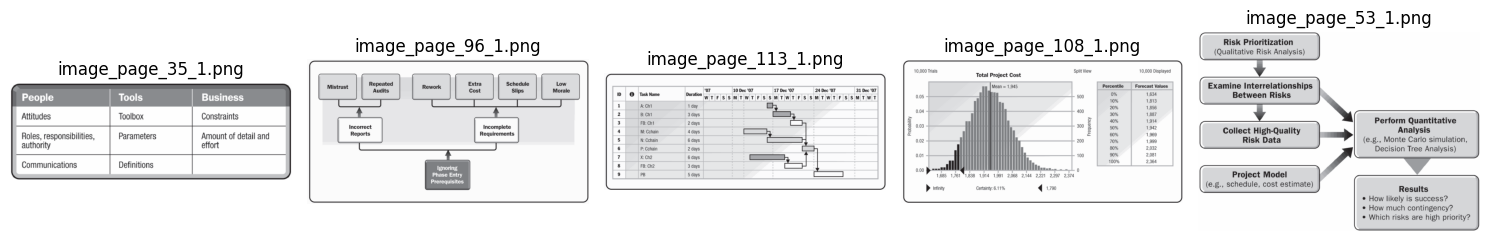

In [32]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory where extracted images are stored
output_dir = "extracted_images"

# Get a list of all images in the output directory
image_files = [f for f in os.listdir(output_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Number of images to display
num_samples = 5

# Randomly select a few images to display
sample_images = random.sample(image_files, min(num_samples, len(image_files)))

# Set up the plot
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for ax, img_file in zip(axes, sample_images):
    img_path = os.path.join(output_dir, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis
    ax.set_title(img_file)  # Set title to the image file name

plt.tight_layout()
plt.show()



# 1. Method 1: OCR Using Tesseract
The first method utilizes Tesseract, a popular Optical Character Recognition (OCR) engine, to extract text from images. This approach is straightforward and works best when the text in the images is clear and in well-defined fonts. Tesseract can handle various image formats such as PNG, JPEG, and others.

In [33]:
# Install Tesseract OCR
!apt-get install tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,959 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123620 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [34]:
import pytesseract
from PIL import Image
# Initialize a list to hold the extracted text
extracted_texts = []

# Loop through each image file in the output directory
for img_file in os.listdir(output_dir):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(output_dir, img_file)
        img = Image.open(img_path)

        # Use pytesseract to extract text from the image
        text = pytesseract.image_to_string(img, lang='eng')
        extracted_texts.append(text)

        print(f"Extracted text from {img_file}:\n{text}\n")

# Now extracted_texts contains the text from all images

Extracted text from image_page_97_1.png:
Step 1: Identify & list organizational Strengths Weaknesses

strengths and weaknesses using
brainstorming

Opportunities

Step 2: Derive opportunities from
strengths, and threats from weaknesses, - B J

01.2
‘-- 02.1
Etc.

using risk metalanguage

 

 

 


Extracted text from image_page_44_1.png:
     
 
   
 
   

High-Quality
Information

Agreed-Upon Definitions

Agreed-Upon Approach


Extracted text from image_page_65_1.png:
   

Risk Response Monitoring

  

  
 
   
  

Project

Management Plan Status .

Risk
Register

  
  
   
 
      
   
 
    
   
  

 

   
   

Additional Fel (ele
risk project
information eA oie) eS

  
  
 

Maetetoye
conditions

  

Stakeholder
Communications

  

Risk Response Control

Invoke Perform additional
contingency risk identification,
plans analysis and

response planning

Lessons
Learned

Integrated Change Control
Updates


Extracted text from image_page_93_1.png:
Issue Invitation
to Bid (ITB)

Quali

This section details the process of text segmentation and the construction of a concept relationship graph based on extracted text from images. The methodology utilizes natural language processing (NLP) tools, including spaCy and NLTK, to identify and analyze relationships among key concepts within the extracted text.


In [35]:

# Load the English model from spaCy
nlp = spacy.load("en_core_web_sm")

# List to hold the segmented data
segmented_data = []

# Loop through each extracted text
for text in extracted_texts:
    # Use spaCy to process the text
    doc = nlp(text)

    # Create a dictionary to hold the identified segments
    segments = {
        "Nouns": [],
        "Verbs": [],
        "Synonyms": []  # We'll handle this later
    }

    # Iterate through the tokens in the text
    for token in doc:
        if token.pos_ == "NOUN":
            segments["Nouns"].append(token.text)
        elif token.pos_ == "VERB":
            segments["Verbs"].append(token.text)

    # Append the segmented data for this text
    segmented_data.append(segments)

    # Print the segmented information for this text
    print(f"Segmented data for text:\nNouns: {segments['Nouns']}\nVerbs: {segments['Verbs']}\n")


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Segmented data for text:
Nouns: ['Step', 'Weaknesses', 'strengths', 'weaknesses', 'Opportunities', 'Step', 'opportunities', 'strengths', 'threats', 'weaknesses', 'B', '.', 'risk', 'metalanguage']
Verbs: ['Identify', 'list', 'using', 'brainstorming', 'using']

Segmented data for text:
Nouns: ['Approach']
Verbs: []

Segmented data for text:
Nouns: ['Risk', 'Risk', 'ele', 'risk', 'project', 'information', 'conditions', 'contingency', 'risk', 'identification', 'analysis', 'response', 'Updates']
Verbs: ['Perform', 'plans', 'planning', 'Learned']

Segmented data for text:
Nouns: ['Bids']
Verbs: []

Segmented data for text:
Nouns: ['%', '%', '%', '%', '%', 'Apr/09', '%', '%', 'Apr/09', '%', 'Apr/09', '%', 'Apr/09', '%', 'Apr/09', '%', '%', '%', 'Apr/09', '%', '%', 'Mar/09', '%', 'Mar/09', '%', 'Mar/09', '%', 'Mar/09', '%', '%', '%']
Verbs: []

Segmented data for text:
Nouns: ['Cause', 'Fact', 'Condition', 'Risk', 'Uncertainty']
Verbs: []

Segmented data for text:
Nouns: ['Note', 'Factors', 'i

In [36]:
import nltk
from nltk.corpus import wordnet

# Download WordNet data if not already downloaded
nltk.download('wordnet')

# Function to find synonyms using WordNet
def find_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Add synonyms to the segments
for segments in segmented_data:
    for noun in segments['Nouns']:
        synonyms = find_synonyms(noun)
        segments['Synonyms'].extend(synonyms)

    # Print updated segments with synonyms
    print(f"Updated Segments with Synonyms:\nNouns: {segments['Nouns']}\nSynonyms: {segments['Synonyms']}\n")


Updated Segments with Synonyms:
Nouns: ['Step', 'Weaknesses', 'strengths', 'weaknesses', 'Opportunities', 'Step', 'opportunities', 'strengths', 'threats', 'weaknesses', 'B', '.', 'risk', 'metalanguage']
Synonyms: ['footfall', 'measure', 'ill-treat', 'step', 'dance_step', 'ill-use', 'footstep', 'abuse', 'footmark', 'whole_tone', 'mistreat', 'whole_step', 'footprint', "stone's_throw", 'stride', 'stair', 'pace', 'maltreat', 'tone', 'gradation', 'tread', 'impuissance', 'failing', 'helplessness', 'weakness', 'strong_suit', 'speciality', 'forte', 'durability', 'intensity_level', 'force', 'persuasiveness', 'intensity', 'military_capability', 'military_strength', 'strong_point', 'lastingness', 'long_suit', 'strength', 'metier', 'forcefulness', 'enduringness', 'specialty', 'posture', 'potency', 'military_posture', 'effectiveness', 'impuissance', 'failing', 'helplessness', 'weakness', 'chance', 'opportunity', 'footfall', 'measure', 'ill-treat', 'step', 'dance_step', 'ill-use', 'footstep', 'abuse

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most Frequent Concepts:
risk: 29
%: 27
days: 12
risks: 8
impact: 8
project: 7
responses: 7
apr/09: 6
management: 6
e: 6
analysis: 5
|: 5
technology: 5
mar/09: 4
definition: 4
probability: 4
weaknesses: 3
opportunities: 3
contingency: 3
schedule: 3


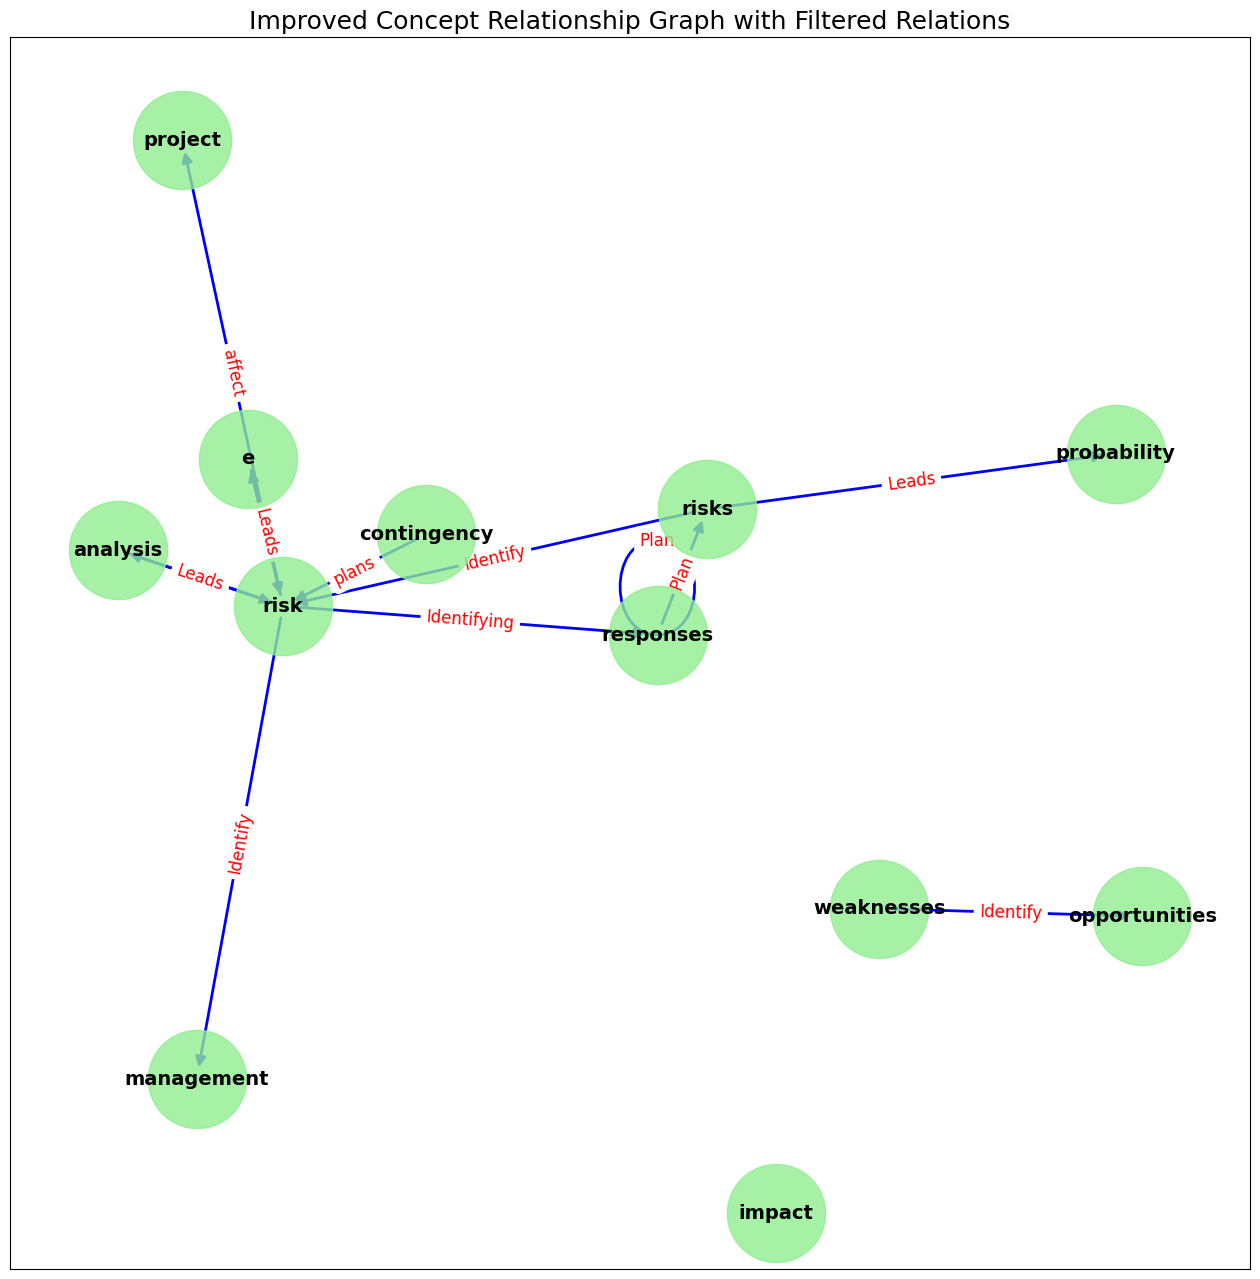

In [37]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Increase the amount of data displayed for a larger scope
MAX_CONCEPTS = 20  # Max number of concepts to show (filtered for relevance)

# Loop through each extracted text
for text in extracted_texts:
    doc = nlp(text)

    # For each sentence in the document
    for sent in doc.sents:
        concepts = []
        relationships = []

        # For each token in the sentence, identify the concept (noun) and relation (verb)
        for token in sent:
            # Nouns as concepts (normalize to lowercase)
            if token.pos_ == "NOUN":
                concept = token.text.lower()  # Convert concept to lowercase
                concepts.append(concept)
                concept_frequency[concept] += 1
            # Verbs as relationships, only keep important verbs
            elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
                relationships.append(token.text)

        # If there are concepts and relationships, assume a connection between them
        if len(concepts) > 1 and len(relationships) > 0:
            for i in range(len(concepts) - 1):
                # Add nodes (concepts) and directed edges (relationships) to the graph
                G.add_node(concepts[i])
                G.add_node(concepts[i + 1])
                G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Create a subgraph with only the top frequent concepts
subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

# Print out the concept frequency for analysis
print("Most Frequent Concepts:")
for concept, freq in most_frequent_concepts:
    print(f"{concept}: {freq}")

# Draw the directed graph with arrows
plt.figure(figsize=(16, 16))  # Increased figure size for a bigger view

# Define node positions using spring layout with more spread
pos = nx.spring_layout(subgraph, seed=42, k=0.5)  # `k` increased to improve spacing

# Draw nodes, edges (with arrows), and labels
nx.draw_networkx_nodes(subgraph, pos, node_size=5000, node_color='lightgreen', alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
nx.draw_networkx_labels(subgraph, pos, font_size=14, font_color='black', font_weight='bold')

# Draw edge labels to show the relationships (verbs)
edge_labels = nx.get_edge_attributes(subgraph, 'label')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=12)

# Set title and display the graph
plt.title('Improved Concept Relationship Graph with Filtered Relations', fontsize=18)
plt.show()


The analysis revealed numerous imperfections in the OCR detection process, prompting us to explore a more advanced methodology. By successfully segmenting the text into meaningful components and constructing a graph that visually represents the relationships between key concepts, we got a good result but we will need a more robust framework for understanding the connections within the extracted text. This approach paves the way for further analysis and insights from the data. Future work can focus on integrating additional NLP techniques or exploring different datasets for broader applications.




#Method 2:
In this method, we enhanced the image extraction process by focusing on chapter-specific elements and utilizing advanced techniques for image captioning and object detection. The following key components were implemented:

##1. Image Extraction by Chapter
Images were systematically extracted based on their corresponding chapter numbers, ensuring organized and relevant data collection. This segmentation allowed for a more structured approach to text analysis.

In [ ]:
# import fitz  # PyMuPDF
# import os
# import re

# def extract_text_and_images_for_all_chapters(pdf_path, chapters, text_output_folder, image_output_folder):
#     """Extracts text and images from specified chapters of a PDF, saving images and text to different folders."""
#     doc = fitz.open(pdf_path)

#     # Create output folders if they don't exist
#     os.makedirs(text_output_folder, exist_ok=True)
#     os.makedirs(image_output_folder, exist_ok=True)

#     for chapter_num, chapter in enumerate(chapters, start=1):
#         start_page = chapter['start_page']
#         end_page = chapter['end_page']
#         header_text = chapter['header_text']
#         footer_text = chapter['footer_text']

#         extracted_text = ""  # Reset text for each chapter
#         image_counter = 1  # Reset image counter for each chapter

#         for page_num in range(start_page - 1, end_page):
#             page = doc.load_page(page_num)
#             text = page.get_text("text")

#             # Iterate over images and save them to the image output folder
#             images = page.get_images(full=True)  # Retrieve all images on the page
#             for img_index, img_info in enumerate(images):
#                 xref = img_info[0]  # Get the XREF of the image
#                 base_image = doc.extract_image(xref)
#                 image_bytes = base_image["image"]
#                 image_ext = base_image["ext"]  # Get image extension
#                 image_filename = f"chapter_{chapter_num}_image_{image_counter:02d}.{image_ext}"  # Format the filename
#                 image_path = os.path.join(image_output_folder, image_filename)

#                 # Save the image to the specified folder
#                 with open(image_path, "wb") as img_file:
#                     img_file.write(image_bytes)

#                 # Create a placeholder text to replace image in the extracted text
#                 placeholder_text = f"[chapter_{chapter_num}_image_{image_counter:02d}]"
#                 extracted_text += placeholder_text + "\n"
#                 image_counter += 1

#             # Remove chapter-specific headers/footers, page numbers, and unwanted text
#             lines = text.splitlines()

#             # Use regex to detect and remove chapter numbers in the header (e.g., "CHAPTER 1")
#             text_without_headers_footers = "\n".join(
#                 line for line in lines
#                 if header_text not in line  # Remove exact header match
#                 and footer_text not in line  # Remove exact footer match
#                 and not re.match(r'^\s*CHAPTER\s+\d+', line)  # Remove lines like "CHAPTER 1"
#                 and not re.match(r'^\s*\d+\s*$', line)  # Remove lines with only page numbers
#             )

#             extracted_text += text_without_headers_footers + "\n\n"

#         # Save the extracted text to a file named as "chapter_X.txt" (e.g., chapter_1.txt) in the text output folder
#         text_file_path = os.path.join(text_output_folder, f"chapter_{chapter_num}.txt")
#         with open(text_file_path, "w", encoding="utf-8") as text_file:
#             text_file.write(extracted_text)

#2. Caption and Placeholder Implementation
Captions and placeholders were effectively integrated into the images. This addition enriched the context for the extracted text and facilitated a clearer understanding of the visual elements associated with each chapter.

In [ ]:
# import os

# def replace_image_placeholders_with_text(chapters, text_output_folder, image_output_folder):
#     """Replaces image placeholders in text files with actual text extracted from images.
#     If the corresponding .txt file for an image is not found, the placeholder is kept."""

#     for chapter_num, chapter in enumerate(chapters, start=1):
#         text_file_path = os.path.join(text_output_folder, f"chapter_{chapter_num}.txt")

#         # Open the text file to read its contents
#         with open(text_file_path, "r", encoding="utf-8") as text_file:
#             text_content = text_file.read()

#         # Replace each placeholder in the text file with the content of the corresponding .txt file
#         image_counter = 1
#         while f"[chapter_{chapter_num}_image_{image_counter:02d}]" in text_content:
#             # Locate the image text file
#             image_text_file = os.path.join(image_output_folder, f"chapter_{chapter_num}_image_{image_counter:02d}.txt")

#             # Check if the .txt file for the image exists
#             if os.path.exists(image_text_file):
#                 # Read the content of the corresponding .txt file
#                 with open(image_text_file, "r", encoding="utf-8") as img_txt_file:
#                     extracted_text = img_txt_file.read()

#                 # Replace the placeholder with the actual text
#                 image_placeholder = f"[chapter_{chapter_num}_image_{image_counter:02d}]"
#                 text_content = text_content.replace(image_placeholder, extracted_text)
#             else:
#                 # If the .txt file doesn't exist, keep the placeholder unchanged
#                 print(f"Text file not found for {image_text_file}, keeping placeholder.")

#             image_counter += 1

#         # Write the updated text back into the file
#         with open(text_file_path, "w", encoding="utf-8") as text_file:
#             text_file.write(text_content)

In [ ]:


# Example usage:
#pdf_path = '/content/drive/MyDrive/PI/practice-standard-project-risk-management.pdf'   # The uploaded PDF path
#text_output_folder = "/content/drive/MyDrive/PI/extracted_texts"  # Specify the folder to save the text files
#image_output_folder = "/content/drive/MyDrive/PI/extracted_images"  # Specify the folder to save the images




In [ ]:
# chapters = [
#     {'start_page': 13, 'end_page': 20, 'header_text': "CHAPTER 1", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 21, 'end_page': 25, 'header_text': "CHAPTER 2", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 25, 'end_page': 30, 'header_text': "CHAPTER 3", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 31, 'end_page': 36, 'header_text': "CHAPTER 4", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 37, 'end_page': 42, 'header_text': "CHAPTER 5", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 43, 'end_page': 48, 'header_text': "CHAPTER 6", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 49, 'end_page': 55, 'header_text': "CHAPTER 7", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 55, 'end_page': 63, 'header_text': "CHAPTER 8", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 63, 'end_page': 68, 'header_text': "CHAPTER 9", 'footer_text': "©2009 Project Management Institute"},
#     # {'start_page': 69, 'end_page': 74, 'header_text': "CHAPTER 10", 'footer_text': "©2009 Project Management Institute"},
#         # Appendices
#     {'start_page': 69, 'end_page': 70, 'header_text': "APPENDIX A", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 71, 'end_page': 73, 'header_text': "APPENDIX B", 'footer_text': "©2009 Project Management Institute"},
#     # {'start_page': 86, 'end_page': 90, 'header_text': "APPENDIX C", 'footer_text': "©2009 Project Management Institute"},
#     {'start_page': 81, 'end_page': 118, 'header_text': "APPENDIX D", 'footer_text': "©2009 Project Management Institute"},
# ]

In [ ]:
# extract_text_and_images_for_all_chapters(pdf_path, chapters, text_output_folder, image_output_folder)

#3. Structural Elements Detection
Elements such as arrows, which indicate causality and relationships between concepts, were identified within the images. This detection was crucial in illustrating the connections among various elements present in the text.
#4. Image Captioning using BLIP
We employed BLIP (Bootstrapping Language-Image Pre-training) for advanced image captioning. This model significantly improved the accuracy and relevance of captions generated for the extracted images, thereby enhancing the overall interpretability of the content.
#5. Object Detection using Detectron2
The Detectron2 framework was utilized for object detection, enabling the identification of key objects and features within the images. This step played a vital role in understanding the visual context of the text.
#6. Text Extraction using Tesseract OCR
Text from the images was extracted using Tesseract OCR, providing a reliable means of converting visual information into machine-readable text. This process facilitated the subsequent analysis of the textual content.

In [ ]:
# # Step 0: Install necessary packages
# !pip install torch torchvision torchaudio transformers
# !pip install detectron2
# !pip install pytesseract
# !pip install openai

# # Step 1: Import necessary libraries
# import os
# import torch
# from transformers import BlipProcessor, BlipForConditionalGeneration
# import cv2
# import pytesseract
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2 import MetadataCatalog

# # Step 2: Load models
# # Load BLIP model for image captioning
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# # Load Detectron2 configuration and model for object detection
# cfg = get_cfg()
# cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Adjust the path as needed
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137257106/model_final_f10217.pkl"
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
# predictor = DefaultPredictor(cfg)

# # Step 3: Define image output folder
# image_output_folder = "/content/drive/MyDrive/PI/extracted_images"  # Replace with your folder path

# # Step 4: Process each image in the output folder
# for image_file in os.listdir(image_output_folder):
#     if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
#         image_path = os.path.join(image_output_folder, image_file)

#         # Load image for processing
#         image = processor(image_path, return_tensors="pt")
#         image_cv2 = cv2.imread(image_path)

#         # Step 5: Image Captioning using BLIP
#         inputs = processor(image, return_tensors="pt")
#         caption_ids = model.generate(**inputs)
#         caption = processor.decode(caption_ids[0], skip_special_tokens=True)

#         # Step 6: Object Detection using Detectron2
#         outputs = predictor(image_cv2)
#         instances = outputs["instances"].pred_classes
#         object_labels = [MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[i] for i in instances]

#         # Step 7: Text Extraction using Tesseract OCR
#         text = pytesseract.image_to_string(image_cv2)

#         # Step 8: Combine Caption and Extracted Information
#         object_list = ', '.join(object_labels) if object_labels else 'no significant objects'
#         extracted_text = text.strip() if text.strip() else 'no visible text in the image'

#         # Generate a more detailed description
#         detailed_description = (
#             f"Caption: {caption}. "
#             f"Detected objects include: {object_list}. "
#             f"Text extracted from the image: '{extracted_text}'."
#         )

#         # Step 9: Generate text with ChatGPT-4 API
#         import openai

#         # Initialize ChatGPT-4 API
#         openai.api_key = "sk-KVNS3iAv1Q3rK0uhM-fd5E0Rtl-JoIPTHNHKkHav9PT3BlbkFJbjmZuUVaRHi6o4iEaoUuh_Lfwuur47syy0FV4yNuAA"  # Replace with your actual API key

#         # Generate response from ChatGPT-4
#         response = openai.ChatCompletion.create(
#             model="gpt-4",
#             messages=[{"role": "user", "content": detailed_description}]
#         )

#         # Extract the generated text
#         generated_text = response['choices'][0]['message']['content'].strip() if response and response['choices'] else ""

#         # Step 10: Save the final description in a text file
#         description_file_path = os.path.join(image_output_folder, f"{os.path.splitext(image_file)[0]}.txt")
#         final_description = f"{detailed_description} Generated Text: '{generated_text}'"

#         with open(description_file_path, 'w') as f:
#             f.write(final_description)

#         print(f"Processed '{image_file}' and saved description to '{description_file_path}'")


In [ ]:

# Call the function to replace the placeholders in text files with the actual text from images
replace_image_placeholders_with_text(chapters, text_output_folder, image_output_folder)



# **Example 1: Data Extraction and Graph Visualization for Chapter 1**

Most Frequent Concepts (from chapter eight):
projects: 88
risks: 41
processes: 38
managements: 36
practices: 23
standards: 19
principles: 14
®s: 9
levels: 9
values: 9


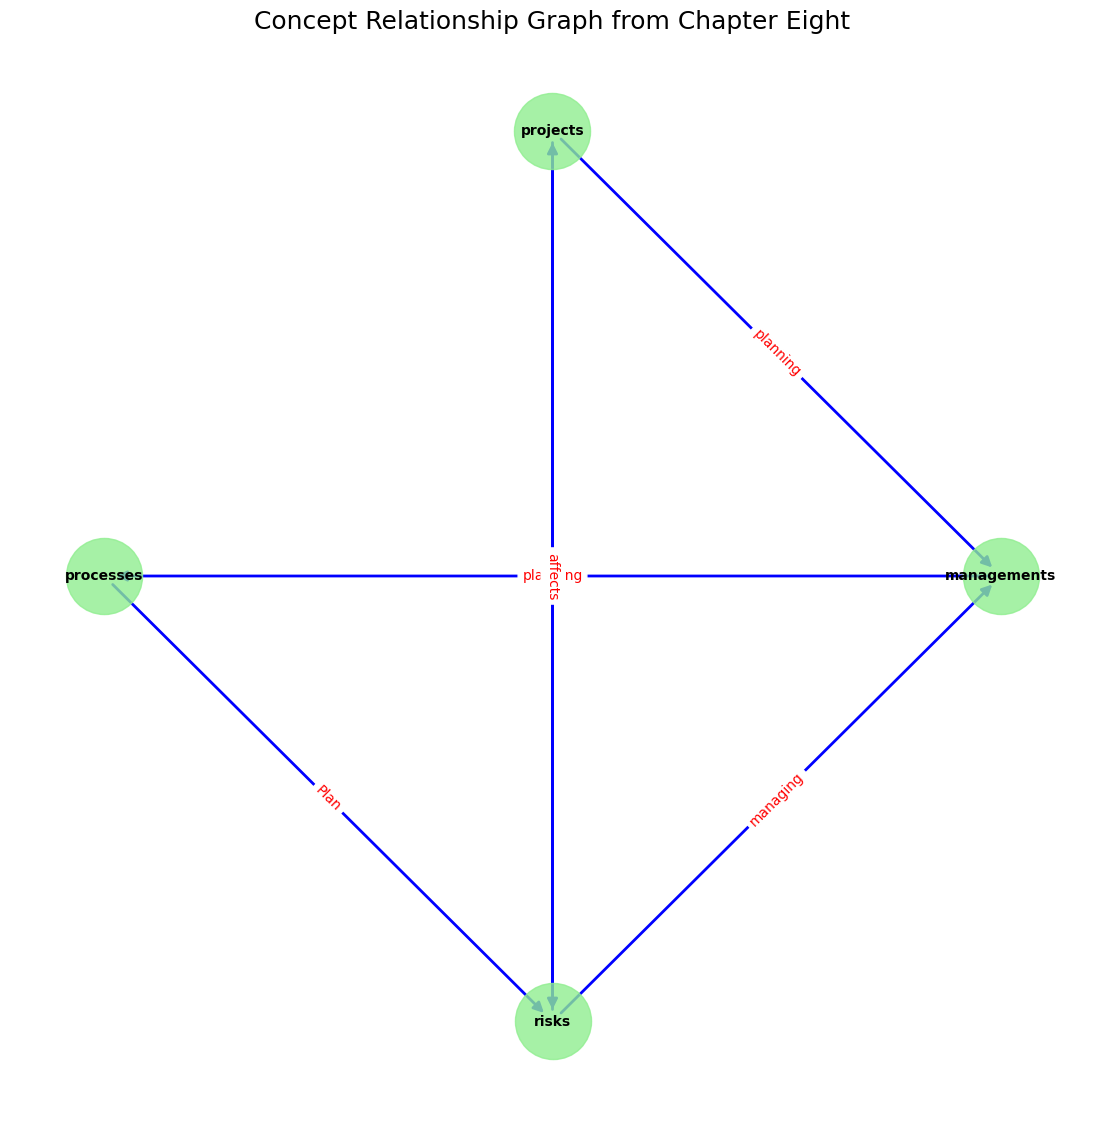

In [38]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Increase the amount of data displayed for a larger scope
MAX_CONCEPTS = 10  # Max number of concepts to show (filtered for relevance)

# Step 1: Load the text file from your drive (update the path accordingly)
file_path = '/content/drive/MyDrive/chapter_1.txt'

# Read the file contents
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Step 2: Process the text file using spaCy
doc = nlp(text)

# Helper function to pluralize nouns
def pluralize(word):
    if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
        return word[:-1] + 'ies'
    elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
        return word + 'es'
    else:
        return word + 's'

# Loop through each sentence in the document
for sent in doc.sents:
    concepts = []
    relationships = []

    # For each token in the sentence, identify the concept (noun) and relation (verb)
    for token in sent:
        # Nouns as concepts (normalize to lowercase and lemmatize)
        if token.pos_ == "NOUN":
            concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

            try:
                concept = pluralize(concept)  # Convert the concept to plural form
                concepts.append(concept)
                concept_frequency[concept] += 1
            except Exception as e:
                print(f"Error pluralizing '{concept}': {e}")

        # Verbs as relationships, only keep important verbs
        elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
            relationships.append(token.text)

    # If there are concepts and relationships, assume a connection between them
    if len(concepts) > 1 and len(relationships) > 0:
        # Create edges between each pair of concepts, using the first relationship found
        for i in range(len(concepts) - 1):
            G.add_node(concepts[i])
            G.add_node(concepts[i + 1])
            G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from chapter eight):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from Chapter One', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# **Example 2: Data Extraction and Graph Visualization for Chapter 8**

Most Frequent Concepts (from chapter eight):
risks: 145
responses: 99
projects: 53
actions: 43
strategies: 24
processes: 23
plans: 23
owners: 23
managements: 19
plannings: 17


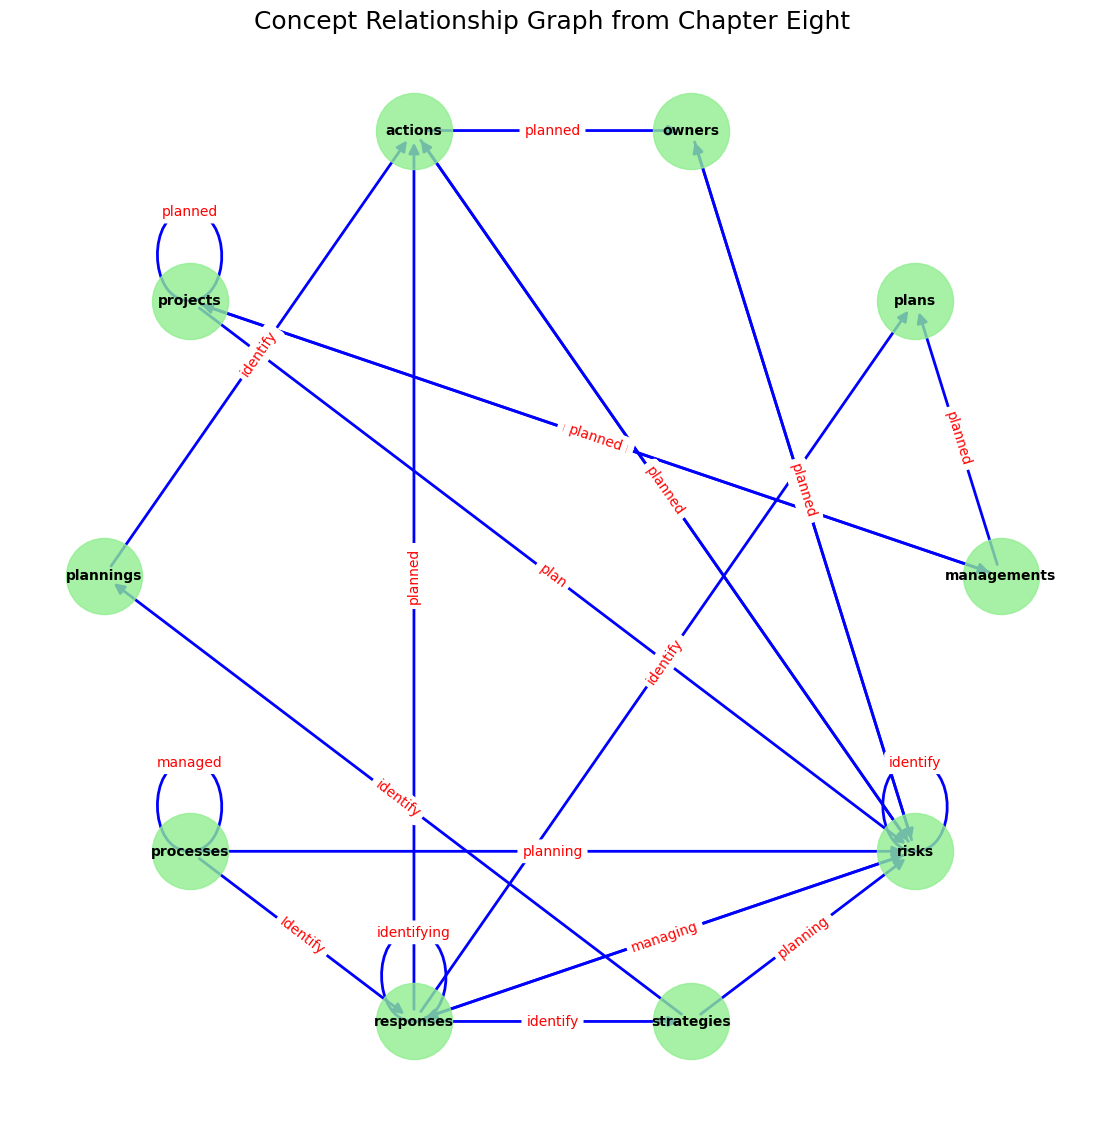

In [39]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Increase the amount of data displayed for a larger scope
MAX_CONCEPTS = 10  # Max number of concepts to show (filtered for relevance)

# Step 1: Load the text file from your drive (update the path accordingly)
file_path = '/content/drive/MyDrive/chapter_8.txt'  # Update with your correct path

# Read the file contents
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Step 2: Process the text file using spaCy
doc = nlp(text)

# Helper function to pluralize nouns
def pluralize(word):
    if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
        return word[:-1] + 'ies'
    elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
        return word + 'es'
    else:
        return word + 's'

# Loop through each sentence in the document
for sent in doc.sents:
    concepts = []
    relationships = []

    # For each token in the sentence, identify the concept (noun) and relation (verb)
    for token in sent:
        # Nouns as concepts (normalize to lowercase and lemmatize)
        if token.pos_ == "NOUN":
            concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

            try:
                concept = pluralize(concept)  # Convert the concept to plural form
                concepts.append(concept)
                concept_frequency[concept] += 1
            except Exception as e:
                print(f"Error pluralizing '{concept}': {e}")

        # Verbs as relationships, only keep important verbs
        elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
            relationships.append(token.text)

    # If there are concepts and relationships, assume a connection between them
    if len(concepts) > 1 and len(relationships) > 0:
        # Create edges between each pair of concepts, using the first relationship found
        for i in range(len(concepts) - 1):
            G.add_node(concepts[i])
            G.add_node(concepts[i + 1])
            G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from chapter eight):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from Chapter Eight', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# **Example 3: Merged Data Extraction and Graph Visualization for Chapter 1 & 8 **


Most Frequent Concepts (from both chapters):
risks: 186
projects: 141
responses: 105
processes: 61
managements: 55
actions: 47
plans: 29
strategies: 24
practices: 23
owners: 23


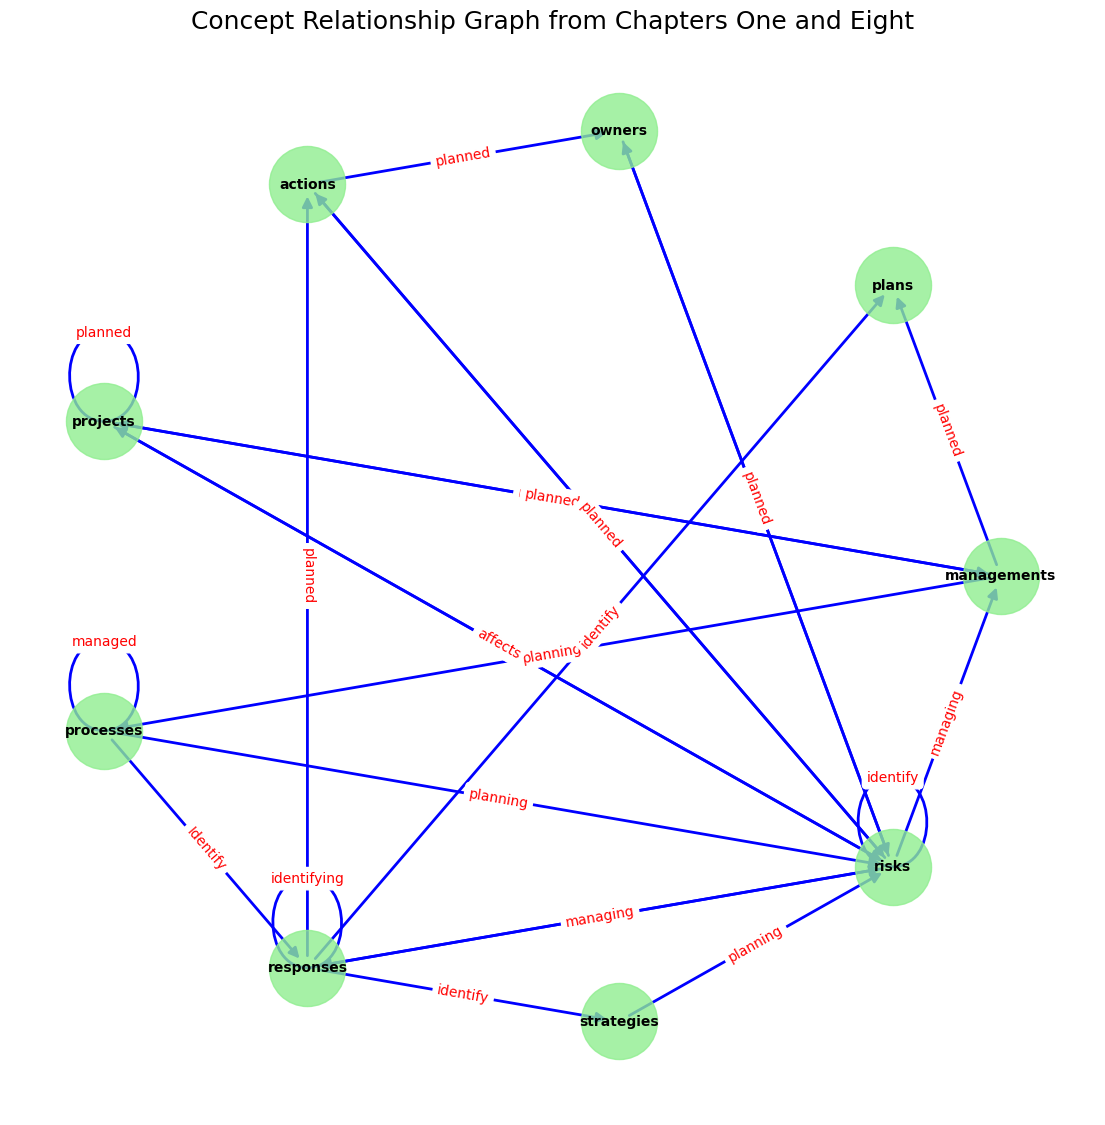

In [40]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph for both chapters
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Maximum number of concepts to show (filtered for relevance)
MAX_CONCEPTS = 10

def process_chapter(file_path):
    """Process the text file to extract concepts and relationships."""
    global G, concept_frequency  # Use the global graph and frequency counter

    # Read the file contents
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Process the text file using spaCy
    doc = nlp(text)

    # Helper function to pluralize nouns
    def pluralize(word):
        if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
            return word[:-1] + 'ies'
        elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
            return word + 'es'
        else:
            return word + 's'

    # Loop through each sentence in the document
    for sent in doc.sents:
        concepts = []
        relationships = []

        # For each token in the sentence, identify the concept (noun) and relation (verb)
        for token in sent:
            # Nouns as concepts (normalize to lowercase and lemmatize)
            if token.pos_ == "NOUN":
                concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

                try:
                    concept = pluralize(concept)  # Convert the concept to plural form
                    concepts.append(concept)
                    concept_frequency[concept] += 1
                except Exception as e:
                    print(f"Error pluralizing '{concept}': {e}")

            # Verbs as relationships, only keep important verbs
            elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
                relationships.append(token.text)

        # If there are concepts and relationships, assume a connection between them
        if len(concepts) > 1 and len(relationships) > 0:
            # Create edges between each pair of concepts, using the first relationship found
            for i in range(len(concepts) - 1):
                G.add_node(concepts[i])
                G.add_node(concepts[i + 1])
                G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Process both chapters
chapter_1_path = '/content/drive/MyDrive/chapter_1.txt'  # Update with your correct path for Chapter 1
chapter_8_path = '/content/drive/MyDrive/chapter_8.txt'  # Update with your correct path for Chapter 8

process_chapter(chapter_1_path)
process_chapter(chapter_8_path)

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from both chapters):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from Chapters One and Eight', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# **Example 4: Data Extraction and Graph Visualization for Chapter 1, 2 & 8**

Most Frequent Concepts (from Chapters One, Two, and Eight):
risks: 260
projects: 222
responses: 110
processes: 87
managements: 83
actions: 55
stakeholders: 39
plans: 33
objectives: 27
strategies: 26
practices: 24
plannings: 23
owners: 23
levels: 21
standards: 20


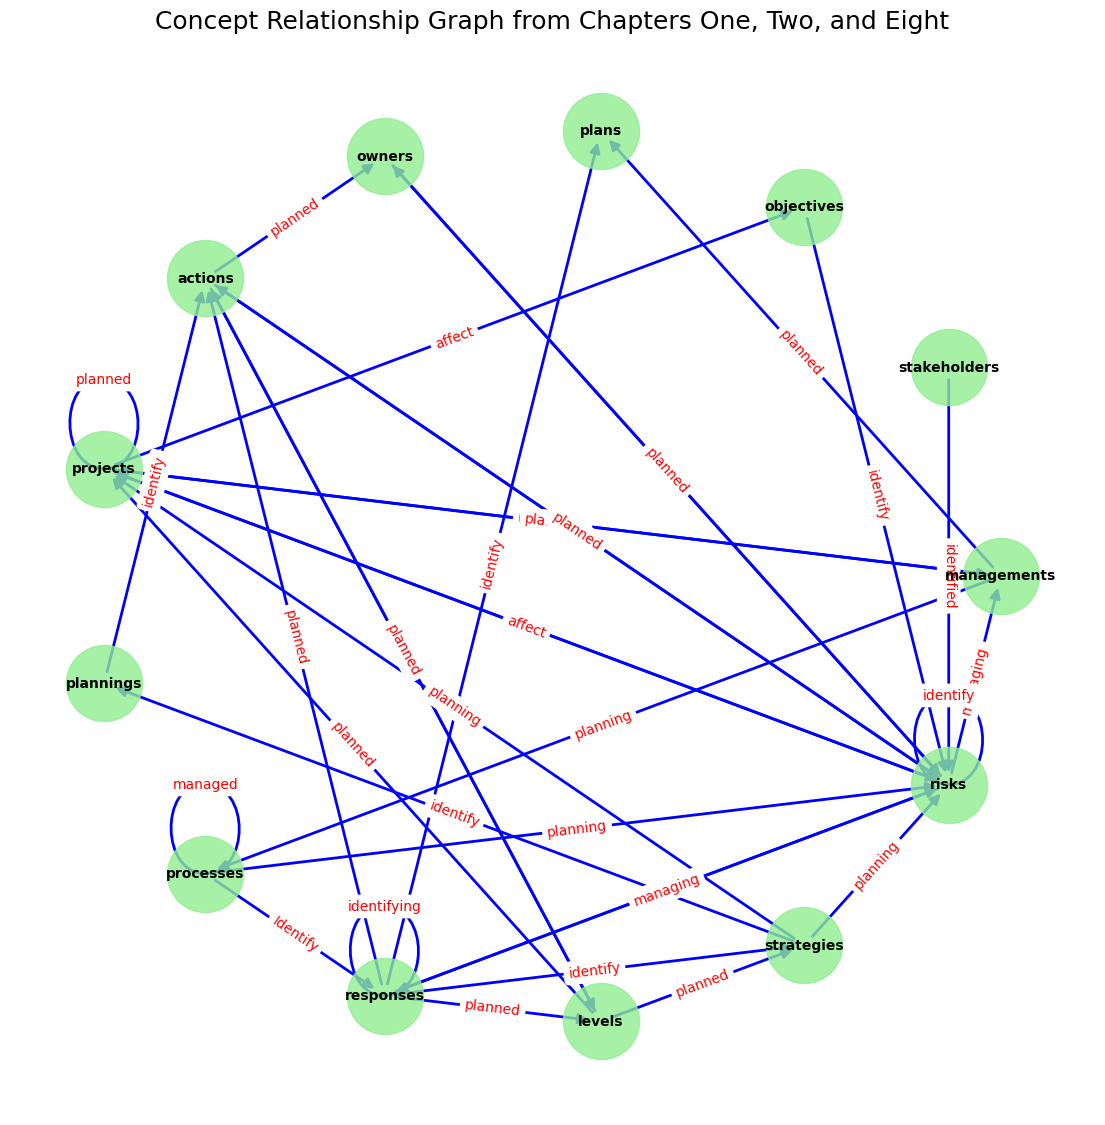

In [41]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph for all chapters
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Maximum number of concepts to show (filtered for relevance)
MAX_CONCEPTS = 15

def process_chapter(file_path):
    """Process the text file to extract concepts and relationships."""
    global G, concept_frequency  # Use the global graph and frequency counter

    # Read the file contents
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Process the text file using spaCy
    doc = nlp(text)

    # Helper function to pluralize nouns
    def pluralize(word):
        if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
            return word[:-1] + 'ies'
        elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
            return word + 'es'
        else:
            return word + 's'

    # Loop through each sentence in the document
    for sent in doc.sents:
        concepts = []
        relationships = []

        # For each token in the sentence, identify the concept (noun) and relation (verb)
        for token in sent:
            # Nouns as concepts (normalize to lowercase and lemmatize)
            if token.pos_ == "NOUN":
                concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

                try:
                    concept = pluralize(concept)  # Convert the concept to plural form
                    concepts.append(concept)
                    concept_frequency[concept] += 1
                except Exception as e:
                    print(f"Error pluralizing '{concept}': {e}")

            # Verbs as relationships, only keep important verbs
            elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
                relationships.append(token.text)

        # If there are concepts and relationships, assume a connection between them
        if len(concepts) > 1 and len(relationships) > 0:
            # Create edges between each pair of concepts, using the first relationship found
            for i in range(len(concepts) - 1):
                G.add_node(concepts[i])
                G.add_node(concepts[i + 1])
                G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Process all chapters
chapter_1_path = '/content/drive/MyDrive/chapter_1.txt'  # Update with your correct path for Chapter 1
chapter_2_path = '/content/drive/MyDrive/chapter_2.txt'  # Update with your correct path for Chapter 2
chapter_8_path = '/content/drive/MyDrive/chapter_8.txt'  # Update with your correct path for Chapter 8

process_chapter(chapter_1_path)
process_chapter(chapter_2_path)
process_chapter(chapter_8_path)

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from Chapters One, Two, and Eight):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from Chapters One, Two, and Eight', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# **Example 5: Data Extraction and Graph Visualization for all the chapters (15 Concepts)**

Most Frequent Concepts (from all Chapters):
risks: 748
projects: 481
processes: 200
managements: 182
responses: 154
objectives: 90
actions: 87
stakeholders: 81
analysises: 81
plans: 77
levels: 58
effects: 48
costs: 47
steps: 44
techniques: 42


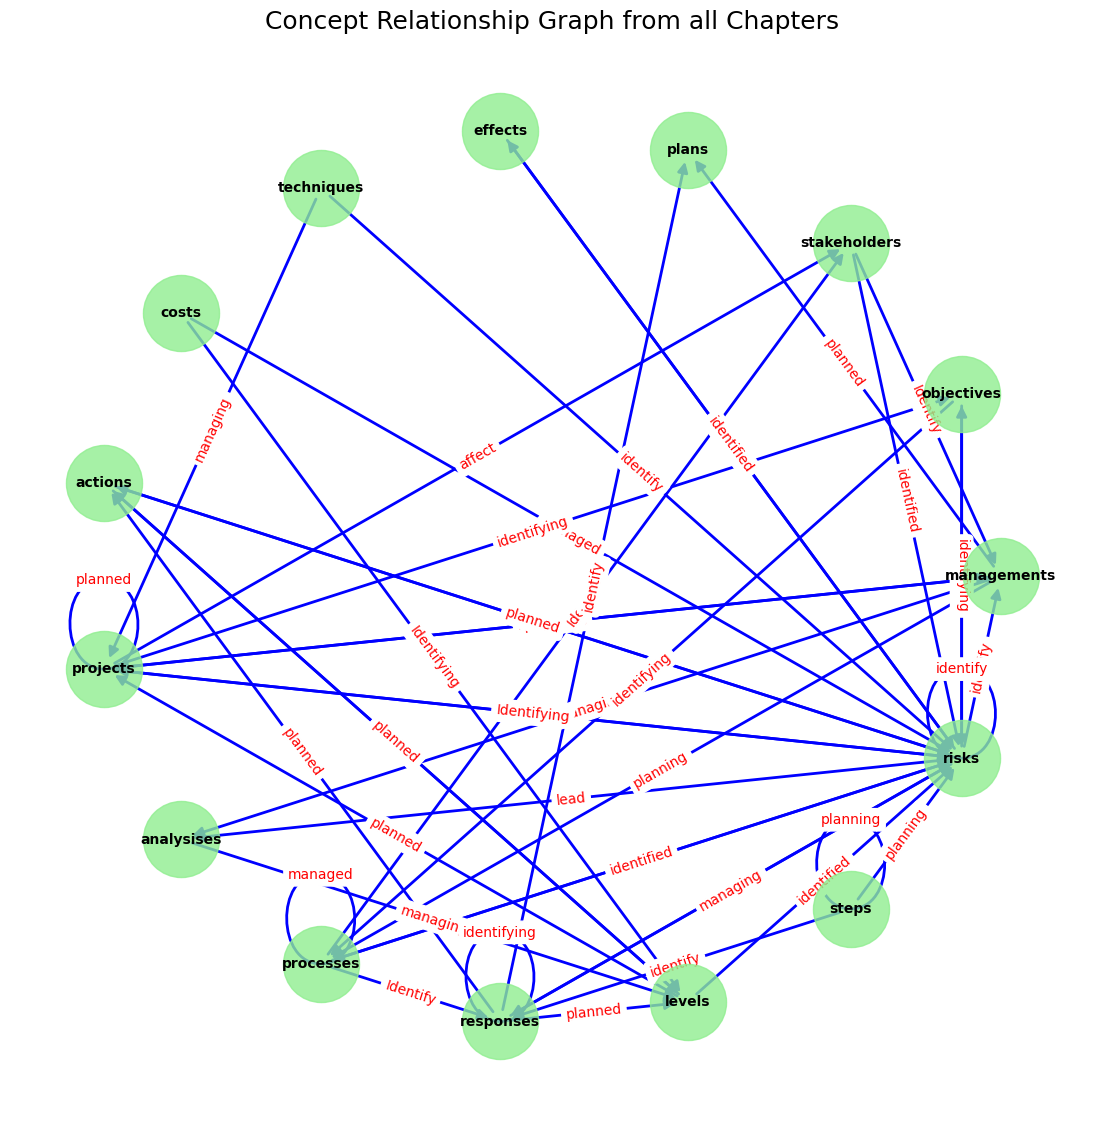

In [42]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph for all chapters
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Maximum number of concepts to show (filtered for relevance)
MAX_CONCEPTS = 15

def process_chapter(file_path):
    """Process the text file to extract concepts and relationships."""
    global G, concept_frequency  # Use the global graph and frequency counter

    # Read the file contents
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Process the text file using spaCy
    doc = nlp(text)

    # Helper function to pluralize nouns
    def pluralize(word):
        if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
            return word[:-1] + 'ies'
        elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
            return word + 'es'
        else:
            return word + 's'

    # Loop through each sentence in the document
    for sent in doc.sents:
        concepts = []
        relationships = []

        # For each token in the sentence, identify the concept (noun) and relation (verb)
        for token in sent:
            # Nouns as concepts (normalize to lowercase and lemmatize)
            if token.pos_ == "NOUN":
                concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

                try:
                    concept = pluralize(concept)  # Convert the concept to plural form
                    concepts.append(concept)
                    concept_frequency[concept] += 1
                except Exception as e:
                    print(f"Error pluralizing '{concept}': {e}")

            # Verbs as relationships, only keep important verbs
            elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
                relationships.append(token.text)

        # If there are concepts and relationships, assume a connection between them
        if len(concepts) > 1 and len(relationships) > 0:
            # Create edges between each pair of concepts, using the first relationship found
            for i in range(len(concepts) - 1):
                G.add_node(concepts[i])
                G.add_node(concepts[i + 1])
                G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Process all chapters
chapter_1_path = '/content/drive/MyDrive/chapter_1.txt'  # Update with your correct path for Chapter 1
chapter_2_path = '/content/drive/MyDrive/chapter_2.txt'  # Update with your correct path for Chapter 2
chapter_3_path = '/content/drive/MyDrive/chapter_3.txt'  # Update with your correct path for Chapter 3
chapter_4_path = '/content/drive/MyDrive/chapter_4.txt'  # Update with your correct path for Chapter 4
chapter_5_path = '/content/drive/MyDrive/chapter_5.txt'  # Update with your correct path for Chapter 5
chapter_6_path = '/content/drive/MyDrive/chapter_6.txt'  # Update with your correct path for Chapter 6
chapter_7_path = '/content/drive/MyDrive/chapter_7.txt'  # Update with your correct path for Chapter 7
chapter_8_path = '/content/drive/MyDrive/chapter_8.txt'  # Update with your correct path for Chapter 8

process_chapter(chapter_1_path)
process_chapter(chapter_2_path)
process_chapter(chapter_3_path)
process_chapter(chapter_4_path)
process_chapter(chapter_5_path)
process_chapter(chapter_6_path)
process_chapter(chapter_7_path)
process_chapter(chapter_8_path)

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from all Chapters):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from all Chapters', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# **Example 5: Data Extraction and Graph Visualization for all the chapters (30 Concepts)**

Most Frequent Concepts (from all Chapters):
risks: 748
projects: 481
processes: 200
managements: 182
responses: 154
objectives: 90
actions: 87
stakeholders: 81
analysises: 81
plans: 77
levels: 58
effects: 48
costs: 47
steps: 44
techniques: 42
results: 41
owners: 39
informations: 38
plannings: 38
strategies: 38
times: 36
successes: 36
resources: 34
tools: 32
approaches: 32
impacts: 32
probabilities: 30
schedules: 30
uncertainties: 30
activities: 29


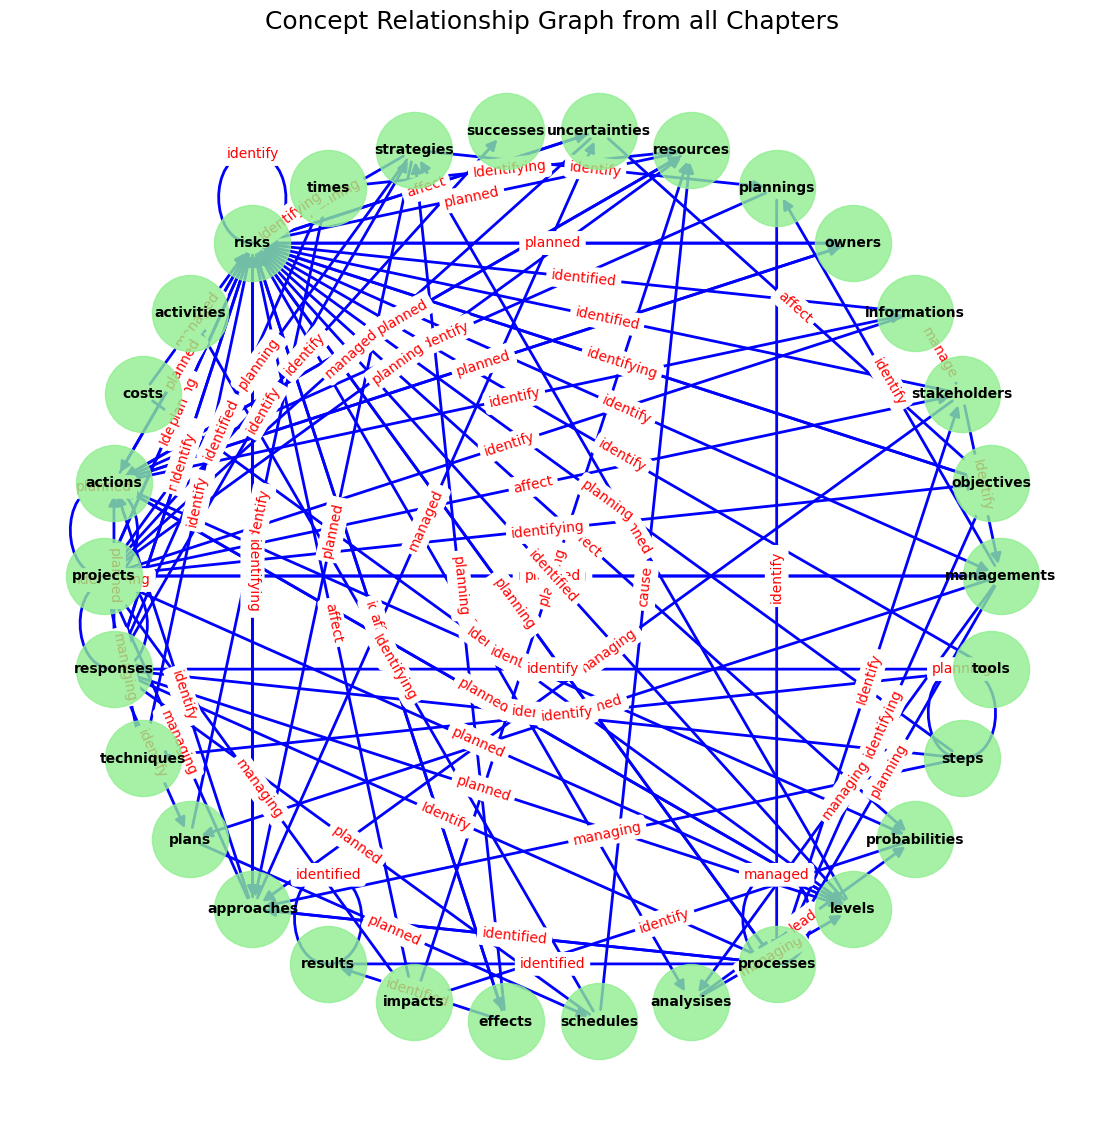

In [43]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize a directed graph for all chapters
G = nx.DiGraph()

# Dictionary to store concept frequencies (normalized to lowercase)
concept_frequency = Counter()

# List of verbs that suggest meaningful relations
important_verbs = ["affect", "lead", "cause", "plan", "identify", "manage"]

# Maximum number of concepts to show (filtered for relevance)
MAX_CONCEPTS = 30

def process_chapter(file_path):
    """Process the text file to extract concepts and relationships."""
    global G, concept_frequency  # Use the global graph and frequency counter

    # Read the file contents
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Process the text file using spaCy
    doc = nlp(text)

    # Helper function to pluralize nouns
    def pluralize(word):
        if word.endswith('y') and len(word) > 1 and word[-2] not in "aeiou":
            return word[:-1] + 'ies'
        elif word.endswith('s') or word.endswith('x') or word.endswith('ch') or word.endswith('sh'):
            return word + 'es'
        else:
            return word + 's'

    # Loop through each sentence in the document
    for sent in doc.sents:
        concepts = []
        relationships = []

        # For each token in the sentence, identify the concept (noun) and relation (verb)
        for token in sent:
            # Nouns as concepts (normalize to lowercase and lemmatize)
            if token.pos_ == "NOUN":
                concept = token.lemma_.lower()  # Convert concept to lowercase and lemmatize

                try:
                    concept = pluralize(concept)  # Convert the concept to plural form
                    concepts.append(concept)
                    concept_frequency[concept] += 1
                except Exception as e:
                    print(f"Error pluralizing '{concept}': {e}")

            # Verbs as relationships, only keep important verbs
            elif token.pos_ == "VERB" and token.lemma_ in important_verbs:
                relationships.append(token.text)

        # If there are concepts and relationships, assume a connection between them
        if len(concepts) > 1 and len(relationships) > 0:
            # Create edges between each pair of concepts, using the first relationship found
            for i in range(len(concepts) - 1):
                G.add_node(concepts[i])
                G.add_node(concepts[i + 1])
                G.add_edge(concepts[i], concepts[i + 1], label=relationships[0])

# Process all chapters
chapter_1_path = '/content/drive/MyDrive/chapter_1.txt'  # Update with your correct path for Chapter 1
chapter_2_path = '/content/drive/MyDrive/chapter_2.txt'  # Update with your correct path for Chapter 2
chapter_3_path = '/content/drive/MyDrive/chapter_3.txt'  # Update with your correct path for Chapter 3
chapter_4_path = '/content/drive/MyDrive/chapter_4.txt'  # Update with your correct path for Chapter 4
chapter_5_path = '/content/drive/MyDrive/chapter_5.txt'  # Update with your correct path for Chapter 5
chapter_6_path = '/content/drive/MyDrive/chapter_6.txt'  # Update with your correct path for Chapter 6
chapter_7_path = '/content/drive/MyDrive/chapter_7.txt'  # Update with your correct path for Chapter 7
chapter_8_path = '/content/drive/MyDrive/chapter_8.txt'  # Update with your correct path for Chapter 8

process_chapter(chapter_1_path)
process_chapter(chapter_2_path)
process_chapter(chapter_3_path)
process_chapter(chapter_4_path)
process_chapter(chapter_5_path)
process_chapter(chapter_6_path)
process_chapter(chapter_7_path)
process_chapter(chapter_8_path)

# Step 3: Get the most frequent concepts (limited to MAX_CONCEPTS)
most_frequent_concepts = concept_frequency.most_common(MAX_CONCEPTS)

# Ensure there's at least one concept to create a subgraph
if most_frequent_concepts:
    # Create a subgraph with only the top frequent concepts
    subgraph = G.subgraph([concept for concept, _ in most_frequent_concepts])

    # Print out the concept frequency for analysis
    print("Most Frequent Concepts (from all Chapters):")
    for concept, freq in most_frequent_concepts:
        print(f"{concept}: {freq}")

    # Step 4: Draw the directed graph with arrows
    plt.figure(figsize=(14, 14))  # Increased figure size for a bigger view

    # Define node positions using a circular layout to avoid overlap
    pos = nx.circular_layout(subgraph)  # Using circular layout for better spacing

    # Draw nodes, edges (with arrows), and labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=3000, node_color='lightgreen', alpha=0.8)  # Reduced node size
    nx.draw_networkx_edges(subgraph, pos, edgelist=subgraph.edges(), edge_color='blue', arrows=True, arrowsize=15, width=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black', font_weight='bold')  # Smaller font size

    # Draw edge labels to show the relationships (verbs)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=10)  # Smaller font size

    # Set title and display the graph
    plt.title('Concept Relationship Graph from all Chapters', fontsize=18)
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()
else:
    print("No frequent concepts found.")


# III- Model Evaluation

The code evaluates key metrics of the final graph by defining a function that computes the number of nodes and edges, determines the degree of each node, and calculates the graph's density. It also computes the average clustering coefficient to assess the degree to which nodes tend to cluster together. Additionally, the function checks if the graph is connected; if so, it calculates the average path length to understand the typical distance between nodes. Finally, all these metrics are printed to provide a comprehensive overview of the graph's structure and properties.



In [44]:
# Evaluate graph metrics
def evaluate_graph(graph):
    # 1. Number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    # 2. Degree of each node
    degrees = dict(graph.degree())

    # 3. Graph Density
    density = nx.density(graph)

    # 4. Average Clustering Coefficient
    clustering_coefficient = nx.average_clustering(graph)

    # 5. Average Path Length (only for connected graphs)
    if nx.is_connected(graph.to_undirected()):
        average_path_length = nx.average_shortest_path_length(graph.to_undirected())
    else:
        average_path_length = "Graph is not connected"

    # 6. Print the metrics
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Degrees of nodes: {degrees}")
    print(f"Graph Density: {density:.4f}")
    print(f"Average Clustering Coefficient: {clustering_coefficient:.4f}")
    print(f"Average Path Length: {average_path_length}")

# Call the evaluation function on your directed graph G
evaluate_graph(G)


Number of nodes: 214
Number of edges: 484
Degrees of nodes: {'processes': 35, 'risks': 114, 'managements': 13, 'responses': 24, 'advances': 2, 'occurrences': 6, 'actions': 16, 'informations': 7, 'projects': 60, 'managers': 2, 'ways': 5, 'parts': 6, 'aspects': 4, 'phases': 2, 'groups': 6, 'addresses': 2, 'concepts': 2, 'designs': 2, 'procurements': 2, 'executions': 2, 'closes': 2, 'outs': 1, 'paradoxes': 1, 'effects': 13, 'events': 9, 'conditions': 7, 'objectives': 11, 'speciﬁcs': 2, 'elements': 4, 'tasks': 3, 'attitudes': 4, 'eds': 6, 'natures': 1, 'circumstances': 1, 'credibilities': 1, 'commitments': 2, 'conclusions': 1, 'interests': 2, 'roles': 1, 'approaches': 15, 'uncertainties': 6, 'examples': 5, 'impacts': 12, 'resources': 17, 'requirements': 2, 'costs': 5, 'durations': 2, 'scopes': 7, 'changes': 6, 'plannings': 6, 'res': 3, 'strategies': 10, 'progresses': 2, 'stakeholders': 15, 'deﬁs': 1, 'steps': 10, 'understandings': 10, 'preconditions': 1, 'implementations': 5, 'thresholds':

#**CONCLUSION**

##The graph consists of 214 nodes and 484 edges, indicating a complex network.

1.   The degree distribution shows variability, with 'risks' being highly interconnected (114 connections) and others like 'advances' and 'paradoxes' having very few (2 and 1 connections).
2.   A graph density of 0.0106 suggests a sparse network with few edges compared to the maximum possible.
3.   The average clustering coefficient of 0.1553 indicates moderate local interconnectedness among nodes.
4.   An average path length of approximately 2.99 suggests efficient communication, allowing connections in about three steps.

Overall, the network balances specialization through central hubs and diversity via less connected nodes.